In [11]:
import sys
sys.path.append(r'C:\\Users\lzowe\OneDrive - The City College of New York\CCNY_Course\Applied_Machine_Learning_and_Data_Mining\codes\project-product-price-prediction')

In [13]:
!pip install keras

In [31]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
matplotlib.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.constrained_layout.use'] = True


# dimension reduction



# model
import lightgbm as lgbm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


from final.random_sampling.even_sample_brand import stratified_sampling_by_brand
from final.feature_extraction.text_vectorization import encode_categories,encode_string_column


from final.model_evaluation.error_function import mape
from final.model_evaluation.visualizations import plot_prediction_price
from final.model_evaluation.regression_cvs import find_train_best_model
from final.model_evaluation.keras_model import neural_network
from final.model_evaluation.regression_evaluation import reg_evaluation, get_ori_price
from final.model_evaluation.visualizations import plot_loss

# Get sample df

In [23]:
df = pd.read_csv("../../data/sampling_50000_brand_name_data.csv")

In [24]:
df.shape

(50000, 48)

In [25]:
df.head(5)

,brand_name,Unnamed: 1,train_id,item_condition_id,brand_name.1,price,shipping,c1,c2,c3,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
0,mitchell ness,219343,219537,1,mitchell ness,40.0,0,men,men s accessories,hat,...,0.324324,0.352941,0.923077,0.392857,0.0,0.034483,0.052632,0.008197,0.000000,0.000000
1,sanuk,1142856,1143963,1,sanuk,38.0,0,woman,shoe,sandal,...,0.108108,0.147059,1.000000,0.285714,0.0,0.000000,0.000000,0.008197,0.001916,0.001183
2,mary kay,805789,806555,2,mary kay,8.0,0,beauty,makeup,makeup sets,...,0.189189,0.205882,0.875000,0.214286,0.0,0.000000,0.000000,0.008197,0.003831,0.000000
3,levi strauss co,146324,146465,2,levi strauss co,32.0,0,woman,jean,slim skinny,...,0.378378,0.382353,0.866667,0.285714,0.0,0.034483,0.000000,0.073770,0.005747,0.001183
4,van,534869,535365,1,van,14.0,1,men,athletic apparel,sock,...,0.054054,0.088235,1.000000,0.142857,0.0,0.103448,0.000000,0.008197,0.001916,0.001183


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   brand_name                        50000 non-null  object 
 1   Unnamed: 1                        50000 non-null  int64  
 2   train_id                          50000 non-null  int64  
 3   item_condition_id                 50000 non-null  int64  
 4   brand_name.1                      50000 non-null  object 
 5   price                             50000 non-null  float64
 6   shipping                          50000 non-null  int64  
 7   c1                                50000 non-null  object 
 8   c2                                50000 non-null  object 
 9   c3                                50000 non-null  object 
 10  clean_name                        50000 non-null  object 
 11  clean_description                 50000 non-null  object 
 12  clea

# Train Test Split

In [27]:
Y = np.log1p(df['price'])
df.drop(['price'], axis=1, inplace=True)
df.head(2)

,brand_name,Unnamed: 1,train_id,item_condition_id,brand_name.1,shipping,c1,c2,c3,clean_name,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
0,mitchell ness,219343,219537,1,mitchell ness,0,men,men s accessories,hat,dallas mavs houston rockets snapbacks,...,0.324324,0.352941,0.923077,0.392857,0.0,0.034483,0.052632,0.008197,0.000000,0.000000
1,sanuk,1142856,1143963,1,sanuk,0,woman,shoe,sandal,sanuk sandals size 7,...,0.108108,0.147059,1.000000,0.285714,0.0,0.000000,0.000000,0.008197,0.001916,0.001183


In [28]:
train_df, test_df , y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=12342)
print('Train size: %s, Test size: %s'%(train_df.shape, test_df.shape))

Train size: (40000, 47), Test size: (10000, 47)


# Vectorization

In [32]:
train_cat_features, test_cat_features, train_cat_features_name = encode_categories(train_df, test_df,
                                                                columns = ['c1','c2','c3','brand_name'], 
                                                                min_df = 10, print_progress=True)

Size of vectorization features of c1 is 12
Size of vectorization features of c2 is 106
Size of vectorization features of c3 is 386
Size of vectorization features of brand_name is 726
Shape of train vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (40000, 1230)
Shape of test vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (10000, 1230)


In [40]:
train_str_features, test_str_features, train_str_features_name = encode_string_column(train_df, test_df,
                                                                   columns=['clean_name', 'clean_description'],
                                                                   min_df=10, max_features={'clean_name':100, 'clean_description':10000}, 
                                                                   print_progress=True)

Size of vectorization features of clean_name is 100
Size of vectorization features of clean_description is 10000
Shape of train vectorization features of ['clean_name', 'clean_description'] is (40000, 10100)
Shape of test vectorization features of ['clean_name', 'clean_description'] is (10000, 10100)


# Combine all features

In [41]:
other_columns = list(train_df.select_dtypes([np.number]).columns)
other_columns.remove('train_id')

In [42]:
train_other_features = train_df[other_columns].values
test_other_features = test_df[other_columns].values
print('Train other features size: %s, Test other features size: %s'%(train_other_features.shape, 
                                                                     test_other_features.shape))

Train other features size: (40000, 39), Test other features size: (10000, 39)


In [43]:
all_train = np.hstack((train_cat_features, train_str_features, train_other_features))
all_test = np.hstack((test_cat_features, test_str_features, test_other_features))
print('Train features size: %s, Test features size: %s'%(all_train.shape, 
                                                         all_test.shape))

Train features size: (40000, 11369), Test features size: (10000, 11369)


In [44]:
del train_cat_features, train_str_features, train_other_features
del test_cat_features, test_str_features, test_other_features

# Dimension Reduction

# PCA

In [45]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(all_train)
X_test_std = sc.transform(all_test)

In [46]:
X_train_std.shape

(40000, 11369)

In [47]:
del all_train, all_test

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500) # reduce features to 50
x_skb_select_train = pca.fit_transform(X_train_std)
x_skb_select_test = pca.transform(X_test_std)
pca.explained_variance_ratio_

array([0.00463841, 0.00195425, 0.00172514, 0.00138833, 0.00130317,
       0.00127445, 0.00122859, 0.00113519, 0.00104399, 0.00100999,
       0.0009907 , 0.00095085, 0.00091805, 0.00089386, 0.00088055,
       0.00087526, 0.00085371, 0.00083587, 0.00079538, 0.00078193,
       0.00077234, 0.00075579, 0.00075026, 0.00074802, 0.00073835,
       0.00072944, 0.00072305, 0.00071398, 0.00070756, 0.00070202,
       0.00069729, 0.00069328, 0.00068033, 0.00067478, 0.00067219,
       0.00066612, 0.00066223, 0.00065957, 0.00064934, 0.00064668,
       0.00064128, 0.00063838, 0.00063173, 0.00062583, 0.00062342,
       0.00062039, 0.00061725, 0.00061524, 0.00060996, 0.00060461,
       0.00060113, 0.00059681, 0.00059514, 0.00059039, 0.00058659,
       0.00058482, 0.00058417, 0.00058212, 0.00057848, 0.00057775,
       0.00057353, 0.00057094, 0.00056679, 0.00056575, 0.00056395,
       0.00055978, 0.00055825, 0.00055574, 0.00055292, 0.00055221,
       0.0005491 , 0.00054409, 0.00054353, 0.00054229, 0.00053

In [49]:
x_skb_select_train.shape

(40000, 500)

In [50]:
x_skb_select_test.shape

(10000, 500)

# Best Hyparameter Test

### Ridge Model - Select K Best

In [51]:
ridge_model = Ridge(max_iter=100, tol=0.05, alpha=6.0)
ridge_model.fit(x_skb_select_train, y_train)
ridge_train_pred = ridge_model.predict(x_skb_select_train)
ridge_test_pred = ridge_model.predict(x_skb_select_test)

In [57]:
ridge_train_pred.max()

6.25442003845227

In [59]:
type(y_train)

pandas.core.series.Series

In [64]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, ridge_train_pred, 
                                                                                   y_test,ridge_test_pred)



In [65]:
pred_train_price.max()

519.3075288766452

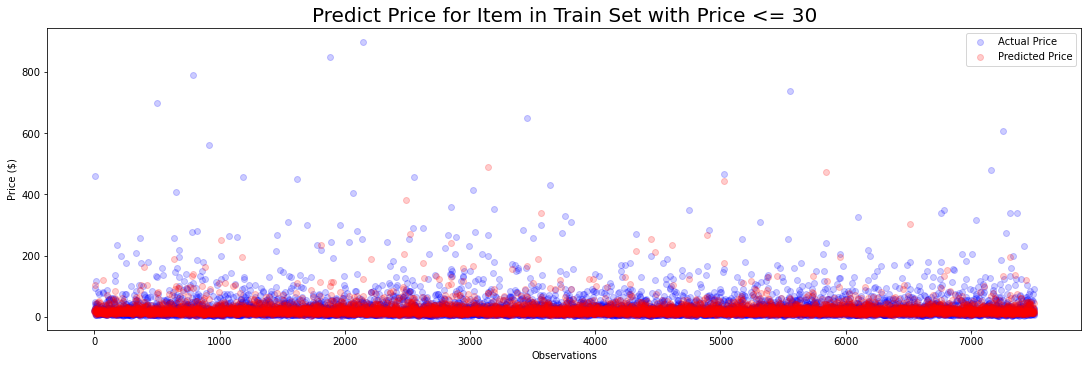

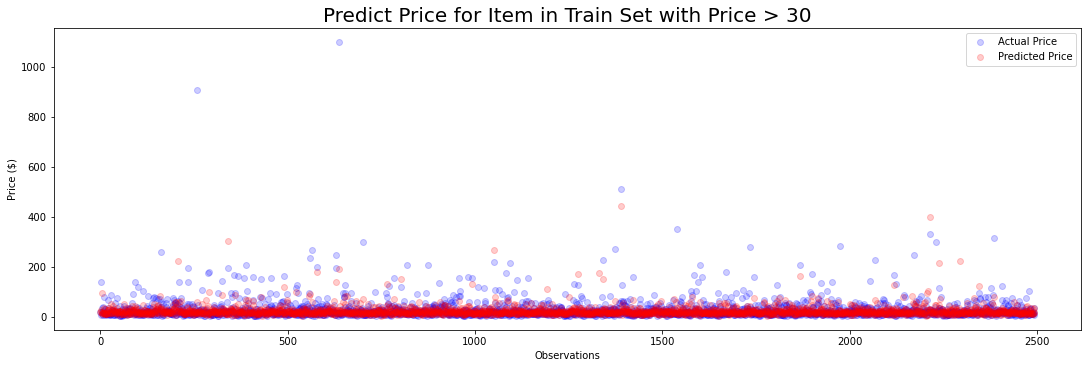

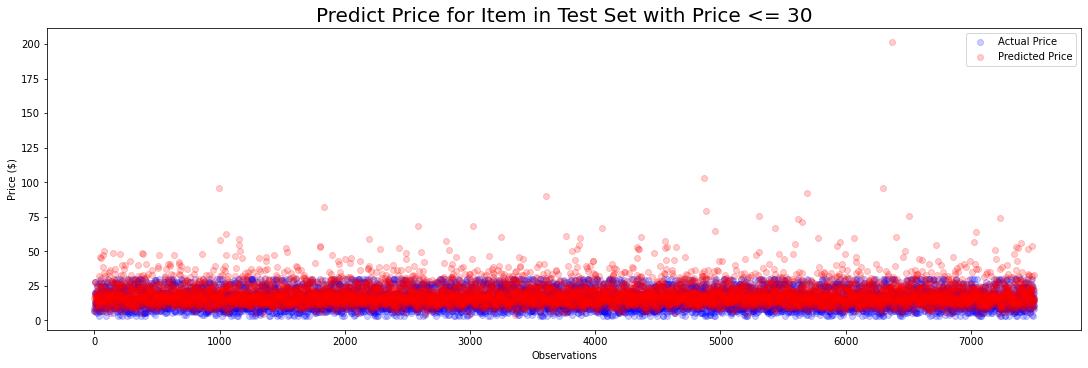

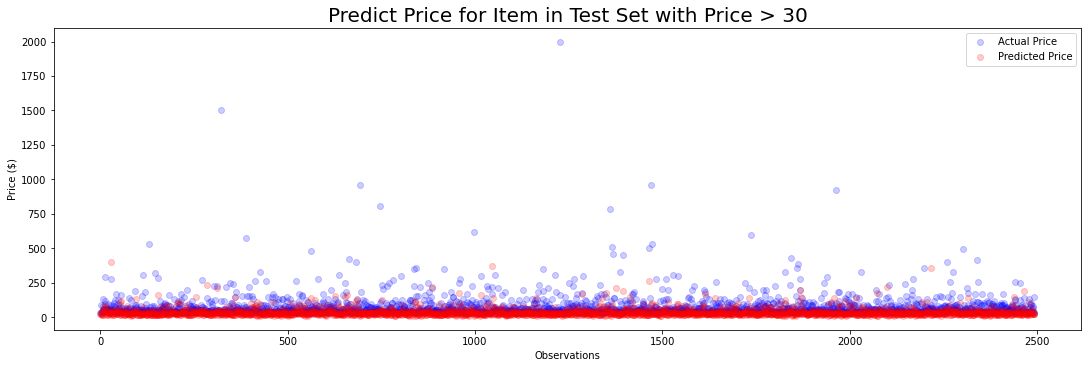

Max Percentage Difference: 1434.54 ---- Original Price 9.00, Predict Price 138.11 
Min Percentage Difference: 0.00 ---- Original Price 18.00, Predict Price 18.00 
Max Percentage Difference: 1434.54 ---- Original Price 9.00, Predict Price 138.11 
Min Percentage Difference: 0.00 ---- Original Price 18.00, Predict Price 18.00 
Max Percentage Difference: 458.03 ---- Original Price 41.00, Predict Price 228.79 
Min Percentage Difference: 0.02 ---- Original Price 40.00, Predict Price 40.01 
Max Percentage Difference: 1341.28 ---- Original Price 14.00, Predict Price 201.78 
Min Percentage Difference: 0.00 ---- Original Price 86.00, Predict Price 86.00 
Max Percentage Difference: 1341.28 ---- Original Price 14.00, Predict Price 201.78 
Min Percentage Difference: 0.00 ---- Original Price 26.00, Predict Price 26.00 
Max Percentage Difference: 319.02 ---- Original Price 85.00, Predict Price 356.17 
Min Percentage Difference: 0.00 ---- Original Price 86.00, Predict Price 86.00 


In [63]:
result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train.values, ridge_train_pred, y_test.values, ridge_test_pred,
               price_split=30,print_result = False)

In [66]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,1434.543501,0.000689,0.601907,0.380395,54.914994,15.032191
Train with Price <= 30,1434.543501,0.000689,0.492786,-0.211251,57.254498,6.570765
Train with Price > 30,458.033502,0.024512,0.852583,-1.285654,47.774186,40.858785
All Test,1341.279077,0.002388,0.608372,0.370792,55.185412,15.306950
Test with Price <= 30,1341.279077,0.002930,0.493711,-0.212760,57.806913,6.582097
Test with Price > 30,319.022992,0.002388,0.866273,-1.371010,47.295683,41.565472


## RandomForestRegressor

### Train with select k best features

In [67]:
rf_model = RandomForestRegressor(n_estimators=200, max_features=50)
rf_model.fit(x_skb_select_train, y_train)
rf_train_pred = rf_model.predict(x_skb_select_train)
rf_test_pred = rf_model.predict(x_skb_select_test)

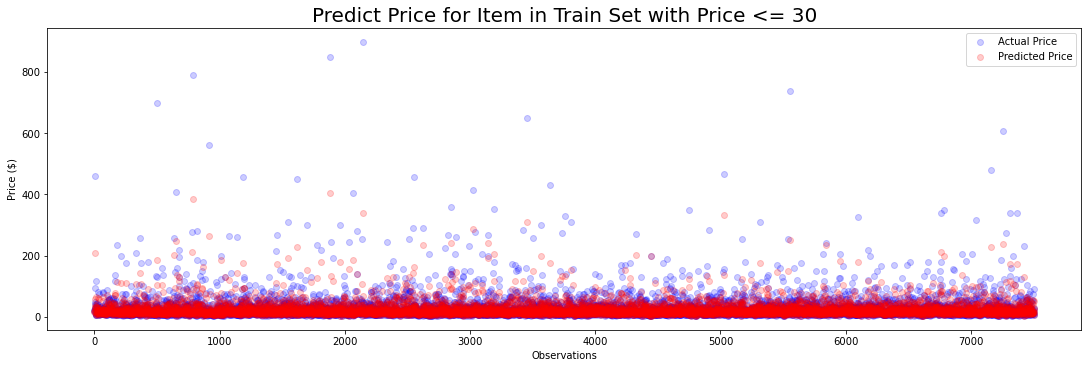

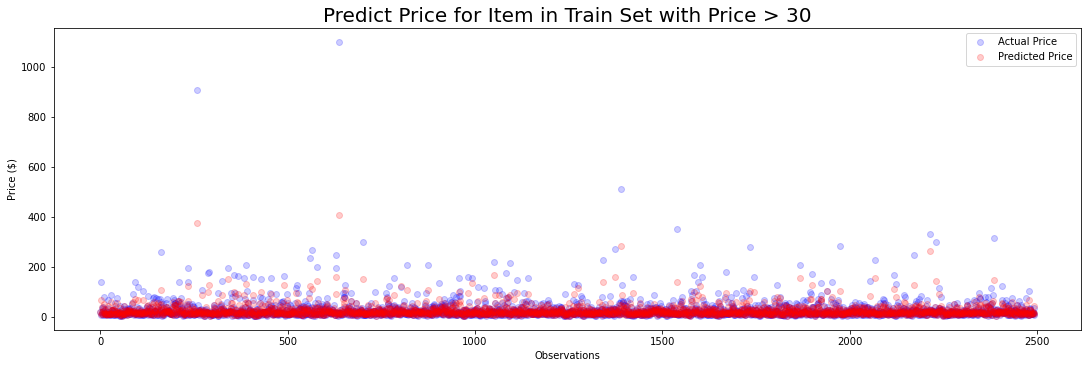

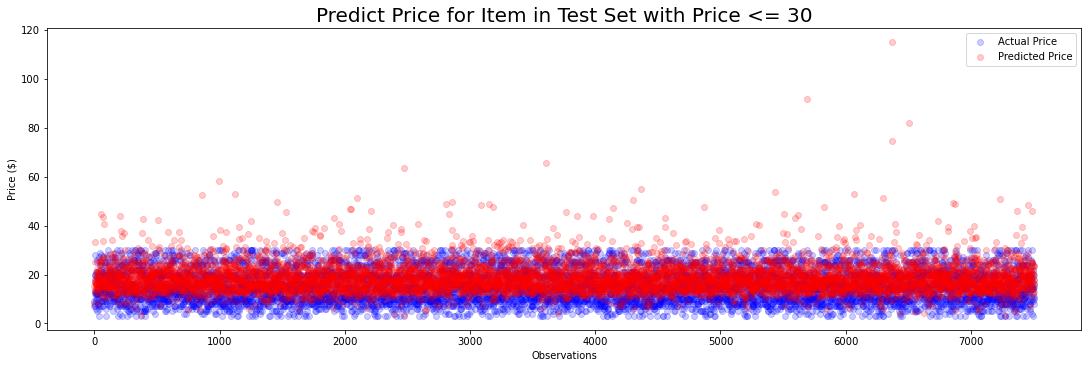

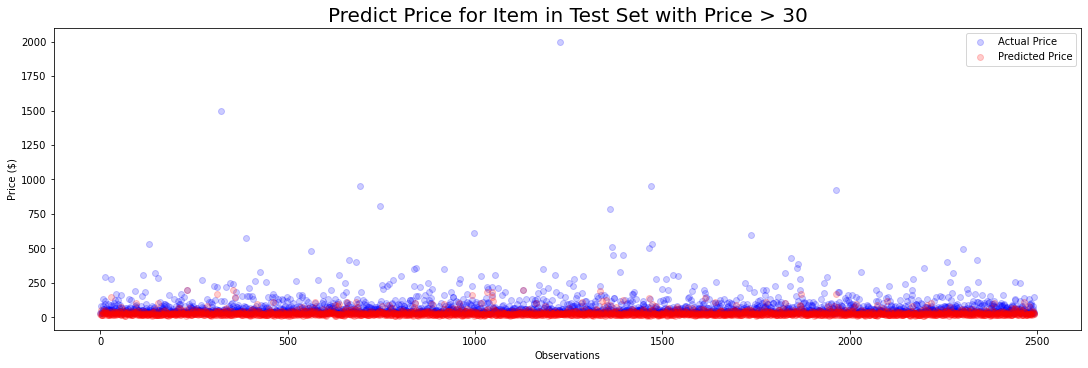

Max Percentage Difference: 173.71 ---- Original Price 12.00, Predict Price 32.85 
Min Percentage Difference: 0.00 ---- Original Price 13.00, Predict Price 13.00 
Max Percentage Difference: 173.71 ---- Original Price 12.00, Predict Price 32.85 
Min Percentage Difference: 0.00 ---- Original Price 13.00, Predict Price 13.00 
Max Percentage Difference: 88.59 ---- Original Price 37.00, Predict Price 69.78 
Min Percentage Difference: 0.01 ---- Original Price 32.00, Predict Price 32.00 
Max Percentage Difference: 851.67 ---- Original Price 3.00, Predict Price 28.55 
Min Percentage Difference: 0.01 ---- Original Price 24.00, Predict Price 24.00 
Max Percentage Difference: 851.67 ---- Original Price 3.00, Predict Price 28.55 
Min Percentage Difference: 0.01 ---- Original Price 24.00, Predict Price 24.00 
Max Percentage Difference: 270.03 ---- Original Price 40.00, Predict Price 148.01 
Min Percentage Difference: 0.11 ---- Original Price 34.00, Predict Price 33.96 


In [69]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, rf_train_pred, 
                                                                                   y_test,rf_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train.values, rf_train_pred, y_test.values, rf_test_pred,
               price_split=30,print_result = False)

In [70]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,173.712216,5.738999e-13,0.227503,0.911482,18.917126,6.981350
Train with Price <= 30,173.712216,5.738999e-13,0.182725,0.833462,17.592969,2.040955
Train with Price > 30,88.585826,8.741716e-03,0.328368,0.660954,22.958817,22.060794
All Test,851.674088,6.418524e-03,0.613652,0.359823,55.256842,15.393059
Test with Price <= 30,851.674088,6.418524e-03,0.482262,-0.157166,57.453080,6.143146
Test with Price > 30,270.029749,1.073530e-01,0.899960,-1.559001,48.646994,43.231811


# Light GBM Regressor

### Train with select k best features

In [72]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=200, max_depth=8,learning_rate=0.1)
lgbm_model.fit(x_skb_select_train, y_train)
lgbm_train_pred = lgbm_model.predict(x_skb_select_train)
lgbm_test_pred = lgbm_model.predict(x_skb_select_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference: 635.02 ---- Original Price 9.00, Predict Price 66.15 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
RMSLE is  0.46707661960022695
R^2  is  0.6268938406685324
Mean Absolute Percentage Error is  41.25612524131107
Mean Absolute Error is  11.799633287034455

Test Result ----------
Max Percentage Difference: 1005.18 ---- Original Price 9.00, Predict Price 99.47 
Min Percentage Difference: 0.00 ---- Original Price 21.00, Predict Price 21.00 
RMSLE is  0.5916389468639592
R^2 is  0.4049272934669348
Mean Absolute Percentage Error is  53.20631142842769
Mean Absolute Error is  14.847594286053514
--------------------------------------------------
For price under $30
Train Result ----------
Max Percentage Difference: 635.02 ---- Original Price 9.00, Predict Price 66.15 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
RM

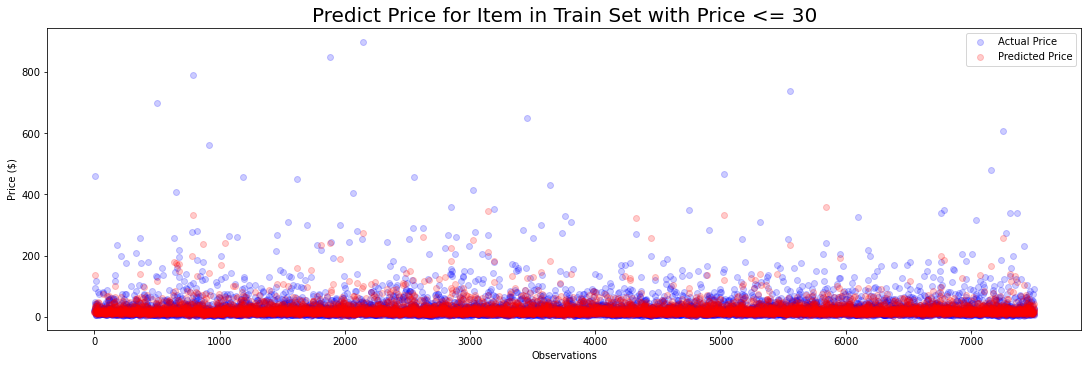

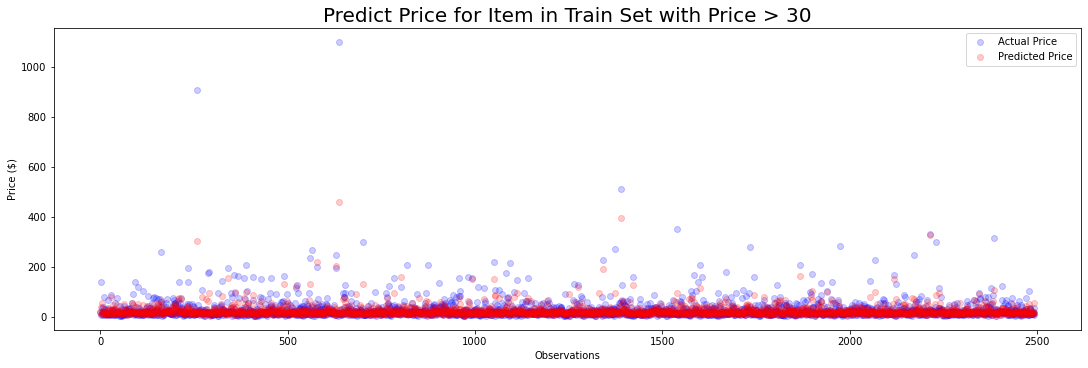

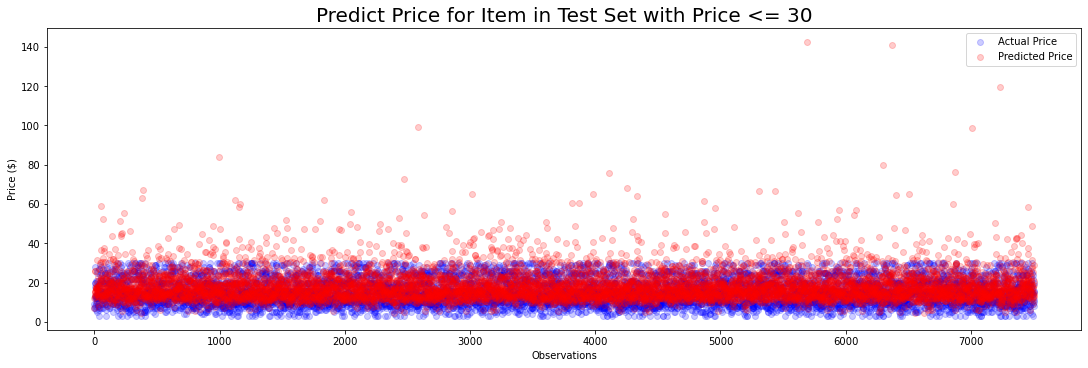

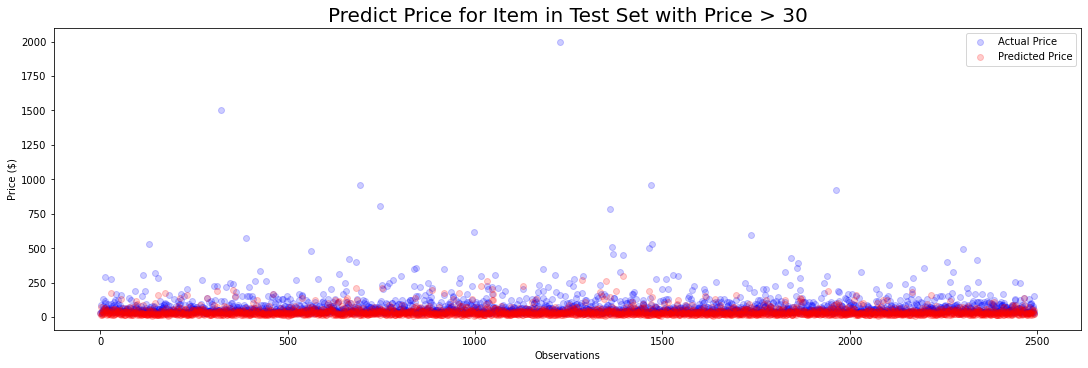

Max Percentage Difference: 635.02 ---- Original Price 9.00, Predict Price 66.15 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
Max Percentage Difference: 635.02 ---- Original Price 9.00, Predict Price 66.15 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
Max Percentage Difference: 259.03 ---- Original Price 37.00, Predict Price 132.84 
Min Percentage Difference: 0.00 ---- Original Price 36.00, Predict Price 36.00 
Max Percentage Difference: 1005.18 ---- Original Price 9.00, Predict Price 99.47 
Min Percentage Difference: 0.00 ---- Original Price 21.00, Predict Price 21.00 
Max Percentage Difference: 1005.18 ---- Original Price 9.00, Predict Price 99.47 
Min Percentage Difference: 0.00 ---- Original Price 21.00, Predict Price 21.00 
Max Percentage Difference: 281.69 ---- Original Price 40.00, Predict Price 152.68 
Min Percentage Difference: 0.11 ---- Original Price 35.00, Predict Price 34.96 


In [73]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, lgbm_train_pred,
                                                                                   y_test, lgbm_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train.values, lgbm_train_pred, y_test.values, lgbm_test_pred,
               price_split=30,print_result = True)

In [74]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,635.023125,0.000917,0.467077,0.626894,41.256125,11.799633
Train with Price <= 30,635.023125,0.000917,0.391407,0.235857,42.136822,4.939379
Train with Price > 30,259.028909,0.003795,0.645321,-0.309448,38.567998,32.739012
All Test,1005.184725,0.000529,0.591639,0.404927,53.206311,14.847594
Test with Price <= 30,1005.184725,0.000529,0.479900,-0.145857,55.494743,6.383776
Test with Price > 30,281.691886,0.113582,0.842845,-1.244498,46.318995,40.320497


# Neural Network

### Train with select k best features

In [75]:
model = neural_network(model_prefix="select_k_best_brand_sample", nodes=[64, 16, 16], dropouts = [0.1,0.1,0.1])
model.fit(x_skb_select_train, y_train.values, x_skb_select_test, y_test.values,
          n_epoch=20,epoch=1, bs=128)

313/313 [==============================] - 1s 3ms/step - loss: 3.6916 - val_loss: 0.9240
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 1.4030 - val_loss: 0.6761
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.0830 - val_loss: 0.5867
Epoch 4/4
313/313 [==============================] - 1s 2ms/step - loss: 0.8941 - val_loss: 0.5251
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.7752 - val_loss: 0.4822
Save Model:  select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_ep5.h5


OSError: Unable to create file (unable to open file: name = 'select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03/select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_ep5.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [76]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                32064     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [77]:
skb_select_loss = np.load("%s/%s_loss.npy"%(model.model_name,model.model_name))[:,:,0]
plot_loss(skb_select_loss[:,0],skb_select_loss[:,1], title="select_k_best_brand_sample_loss")

FileNotFoundError: [Errno 2] No such file or directory: 'select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03/select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_loss.npy'

In [ ]:
model.model_name

In [ ]:
model = neural_network(model_name = "select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_ep20.h5")

In [ ]:
model.model.summary()

In [ ]:
skb_select_train_pred = model.predict(x_skb_select_train)
skb_select_test_pred = model.predict(x_skb_select_test)

In [ ]:
result_df = model.evaluation(y_train, skb_select_train_pred, y_test, skb_select_test_pred, price_split=30,
                                                print_result = False)

In [ ]:
result_df 